# Building makemore Part 2

## 1. Bengio et al. 2003 (MLP language model) paper walkthrough

## 2. (re-)building our training dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for word in words[:5]:
    print(word)
    context = [0] * block_size
    for ch in word + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[ix] for ix in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## 3. implementing the embedding lookup table

In [7]:
C = torch.randn((27, 2))

In [8]:
C[5]

tensor([-1.8209, -0.5931])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.8209, -0.5931])

In [10]:
C[[5, 6, 7]]

tensor([[-1.8209, -0.5931],
        [-0.8859,  1.0109],
        [ 2.2858, -1.0074]])

In [11]:
C[torch.tensor([5, 6, 7, 7, 7, 7, 7])]

tensor([[-1.8209, -0.5931],
        [-0.8859,  1.0109],
        [ 2.2858, -1.0074],
        [ 2.2858, -1.0074],
        [ 2.2858, -1.0074],
        [ 2.2858, -1.0074],
        [ 2.2858, -1.0074]])

In [12]:
C[X].shape

torch.Size([32, 3, 2])

In [13]:
X[13, 2] # index of 'a'

tensor(1)

In [14]:
C[X[13, 2]] # embedding of 'a'

tensor([0.3549, 0.2829])

In [15]:
C[1]

tensor([0.3549, 0.2829])

In [16]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## 4. implementing the hidden layer + internals of torch.Tensor: storage, views

In [17]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100,))

In [18]:
emb[:, 0, :].shape

torch.Size([32, 2])

In [19]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [20]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [21]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [22]:
a.shape

torch.Size([18])

In [23]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [24]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [25]:
a.storage()

/var/folders/vg/2q_11n4x66x29j328zgfm1rw0000gn/T/ipykernel_80135/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [26]:
emb.shape

torch.Size([32, 3, 2])

In [27]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [28]:
emb.view(emb.shape[0], 6) @ W1 + b1 == emb.view(-1, 6) @ W1 + b1

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [29]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

## 5. implementing the output layer

In [30]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

In [31]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

## 6. implementing the negative log likelihood loss

In [32]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [33]:
prob[torch.arange(32), Y]

tensor([1.0751e-11, 7.7796e-07, 1.0638e-16, 1.6419e-07, 1.7207e-10, 2.2748e-06,
        2.0500e-04, 1.1251e-11, 3.8086e-02, 3.8462e-06, 1.2221e-06, 6.7444e-08,
        9.1617e-10, 9.7336e-10, 8.9301e-11, 7.5513e-08, 1.9083e-04, 6.0049e-02,
        2.0134e-02, 6.5050e-14, 2.9282e-09, 6.0976e-10, 1.4187e-11, 3.0595e-09,
        1.1649e-06, 4.4868e-07, 1.5249e-06, 1.5755e-01, 2.0646e-14, 1.2057e-08,
        3.5636e-11, 1.2387e-04])

In [34]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.0401)

## 7. summary of the full network

In [35]:
X.shape, Y.shape # full dataset

(torch.Size([32, 3]), torch.Size([32]))

In [36]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

In [37]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [38]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

## 8. introducing F.cross_entropy and why

In [39]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [ ]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(dim=1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # same as above but more efficient and numerically stable 
loss

tensor(17.7697)

In [43]:
# consider this fail case
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
prob = counts / counts.sum()
print(counts, prob)

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]) tensor([0., 0., 0., nan])


## 9. implementing the training loop, overfitting one batch

In [45]:
for p in parameters:
    p.requires_grad = True

for i in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

0.25608494877815247


In [47]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([13.3422, 17.8070, 20.6086, 20.6231, 16.7472, 13.3422, 16.0094, 14.1817,
        15.9240, 18.3747, 15.9524, 20.9386, 13.3422, 17.1233, 17.1447, 20.0737,
        13.3422, 16.6003, 15.1165, 17.0719, 18.5964, 15.9802, 10.8856, 10.6973,
        15.5135, 13.3422, 16.1900, 16.9852, 12.7503, 16.2095, 19.0979, 16.0357],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [48]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## 10. training on the full dataset, minibatches

In [51]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[ix] for ix in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [53]:
X.shape, Y.shape # full dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [54]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

In [55]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [ ]:
for p in parameters:
    p.requires_grad = True

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

2.8164255619049072


In [ ]:
# check loss on the full dataset
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6566, grad_fn=<NllLossBackward0>)

## 11. finding a good initial learning rate

In [61]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [67]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lri = []
lossi = []

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

8.276185989379883


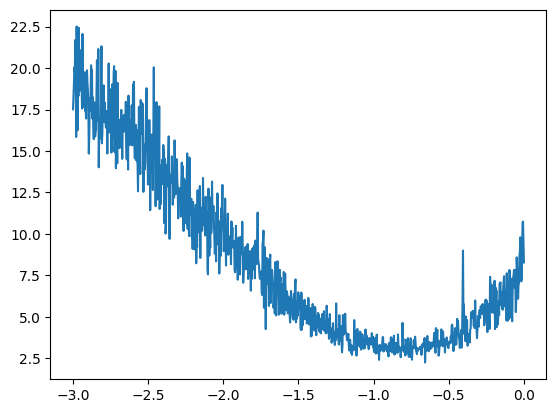

In [68]:
plt.plot(lri, lossi)

In [72]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for i in range(100000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 # optimal learning rate; can also decay it over time
    for p in parameters:
        p.data -= lr * p.grad
    

print(loss.item())

2.1362740993499756


In [73]:
# check loss on the full dataset
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3144, grad_fn=<NllLossBackward0>)

## 12. splitting up the dataset into train/val/test splits and why